In [2]:
import cv2
import sys
import argparse
import numpy as np
import torch
from pathlib import Path
from matplotlib import pyplot as plt
from typing import Any, Dict, List

from sam_segment import predict_masks_with_sam
from stable_diffusion_inpaint import fill_img_with_sd
from utils import load_img_to_array, save_array_to_img, dilate_mask, \
    show_mask, show_points, get_clicked_point

/raid/coss07/anaconda3/envs/IA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-15 07:03:05.990841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 07:03:05.990925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 07:03:05.990977: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 07:03:06.010066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow b

#### Parameters

In [3]:

input_img = '../wim_data/train/images/2023-04-21_48.mp4#t=0.jpg'
point_labels = [1]
sam_model_type = "vit_h"
sam_ckpt = './pretrained_models/sam_vit_h_4b8939.pth'

In [4]:
def normalized_coordinate_to_absolute(norm_x, norm_y, image_width=1280, image_height=720):
    abs_x = int(norm_x * image_width)
    abs_y = int(norm_y * image_height)
    return [abs_x, abs_y]

In [5]:
x_center, y_center = 0.3401102687801516, 0.871380974264706
latest_coords = normalized_coordinate_to_absolute(x_center, y_center)#0.3401102687801516, 0.871380974264706
latest_coords

[435, 627]

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img = load_img_to_array(input_img)

In [7]:
masks, _, _ = predict_masks_with_sam(
        img,
        [latest_coords],
        point_labels,
        model_type=sam_model_type,
        ckpt_p=sam_ckpt,
        device=device,
    )

In [8]:
masks = masks.astype(np.uint8)* 255

In [40]:
masks

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [9]:
mask3 = masks[2]

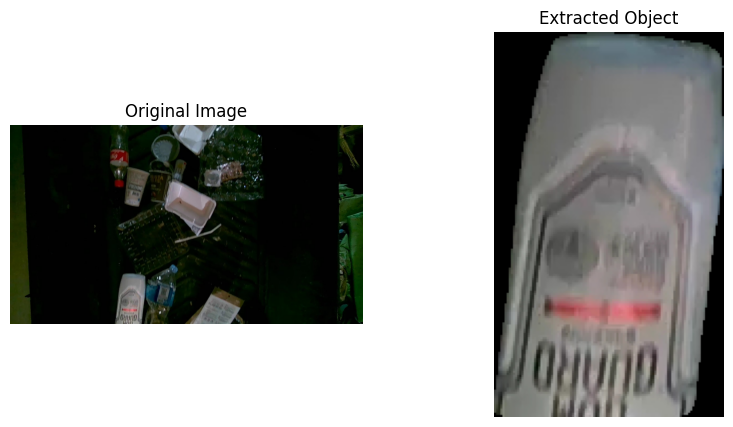

In [10]:
# Ensure the mask is a binary image
extracted_object = cv2.bitwise_and(img, img, mask=mask3)

# Optionally, crop the image to the bounding box of the object
x, y, w, h = cv2.boundingRect(mask3)  # Get bounding box coordinates
cropped_object = extracted_object[y:y+h, x:x+w]

# Show the result using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_object)
plt.title('Extracted Object')
plt.axis('off')

plt.show()


In [36]:

# Apply the dilate_mask function
#dilated_mask = dilate_mask(mask, dilate_factor=15)
transposed_image = mask3.transpose(1, 2, 0)
# Visualize the original and dilated masks
plt.figure(figsize=(10, 5))

plt.subplot(1, 1, 1)
plt.imshow(transposed_image, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(dilated_mask, cmap='gray')
# plt.title('Dilated Mask')
# plt.axis('off')

plt.show()


ValueError: axes don't match array